Check Python version

In [9]:
!python --version

Python 3.10.14


Import libraries

In [10]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [11]:
# Local directory
data_dir = '../datasets/climate'
file_name = 'temp_anom_w_forcing'
file_path = f'{data_dir}/{file_name}.csv'

In [12]:
dataset = pd.read_csv(file_path)

In [13]:
dataset.shape

(163, 11)

In [14]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [15]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [16]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


Define the required time and target columns

In [17]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [18]:
# dataset[target_col] = dataset[target_col].astype(float)

In [19]:
# dataset.head()

Split dataset into train and test sets

In [20]:
train_size = 0.8
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

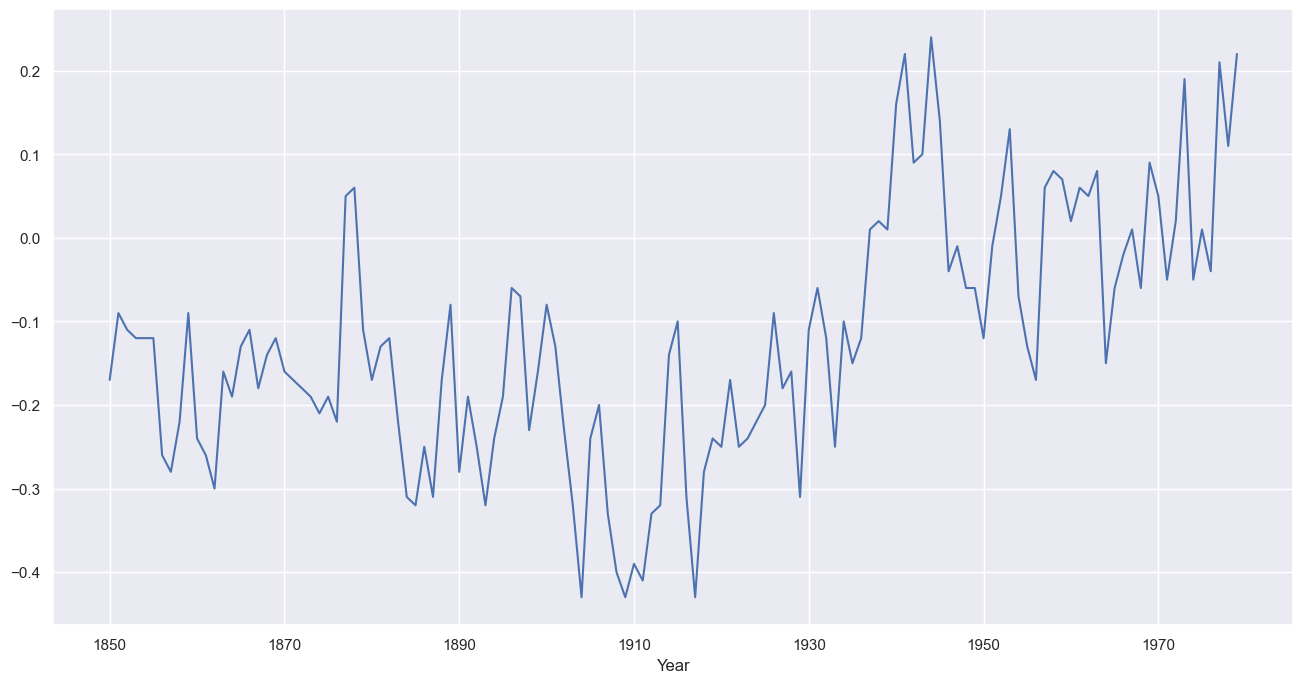

In [21]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [22]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [23]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [24]:
# Default model request
# model_request = {
#     'type': 'meta_lr',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#         ],
#     },
# }

# Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# np_external_model_request = None

# Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_naive'},
            {'type': 'darts_seasonalnaive'},
            {'type': 'darts_autotheta'},
            {'type': 'stats_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autoets'},
            {'type': 'darts_autoarima'},
            {'type': 'stats_autoarima'},
            # {'type': 'darts_tbats'},
            # {'type': 'darts_linearregression'},
            {'type': 'darts_lightgbm',
             'params': {
                 'lags': 12,
                 'output_chunk_length': 6,
                 'verbose': -1
            }}
            # {'type': 'neuralprophet',
            #  'external_params': np_external_model_request
            # }  # Onboard NeuralProphet external service
        ],
    },
}

This is for JSON model_request

In [25]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [26]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [27]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [28]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [29]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [30]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [31]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 5.14 s


In [32]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCMuaEQAAABAABt8GABgAAABt/gUAKbIAAD+AAGVsaZOMb5Rsb4xtlARhaZRzcmGUKIwudG2UTZNhLhRscGwVb2kMdIyMeUMolHAxKE7/YgDgiQAYdYyTh1IYY2VlX5RzbnUKZChoaAECUpT/dOAAqh+UlB1jZWUSdGSMbZMTX3JfaUFrcG95aWFyuJSJBP9Lcwp0HSJLTZRO/0MBlOAAM+BwAB+UBYyUc5RtZXR0jGFhjJRvaWJiaXWBdIwKbG5llHOUUx9vZSgFlGiHCTgoSv9dAQEBAXRvlJSUS4yUTkqUWMAhxx/WUC7w+mJ9IJSFaGhoaH0uYQZdYYxjCWGMlGhoYn0alAFLaOBw2uARAB9LUoWXaIcJKKWpS2g/VSeHR/99S4YglIWUS///bgGJpR9I692AI8a4W/6hkzbZfG4RtFdJ7I8yJMdqDf+iRejafR8gw7VY+56QM9Z5aw6xVEbpjC/SdRi7rVDzlogrznFjBh+pTD7hhCcZvF8C9Jc63c9yFbiqTfCThSjLbmADpkk73h+BJBa5XP/xlDfazG8StadK7ZCCJchrXQCjRjjbfiETth9ZlBtfbHNllIdoYlJ9gYUHeJOMjIyPFJRohSifo6d0hh8dIktIAAC/vwAAv7/AaD+US4loaJSUfQAoaEt10JRzbR+BkzpoaAFdpKhiUiCUhSalaAAunj8ALHRoHSJLlGhoaB+UKGjLaId0f4NLBRRtcE1slHNzAHOUKGRkZS5ldkGTjB9uc3NyaXOUZYx4b2FEeX1vaGF2lFaUlHNfeG94YWVwgR9haFZOAlJO/yhLdACUaIho/wCUlBAuAdQ8D+K1HfDDlx/+0aV44LOGWcGUZzqidUkcg1cq/WU4C95GGezAJ/rOoR8J3K+C6r2QYzcK3bAY676R+cyfc9qugVS8j2I1nXBDFh9+USX4YDMG2UEU57oi9cicA9eqfeW4i17GmWw/p3pOIR+IXC8Ca

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [33]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [34]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [35]:
model = train_json_out['model']

Forecast API JSON Payload

In [36]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [37]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [38]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 2.09 s


In [39]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1980', 0.10331674599809504],
  ['1981', 0.1801465230132687],
  ['1982', 0.10882717374145012],
  ['1983', 0.1378122381007675],
  ['1984', 0.06909777367269203],
  ['1985', 0.16072276072451164],
  ['1986', 0.09581969664481028],
  ['1987', 0.12626420466259436],
  ['1988', 0.048213788394855545],
  ['1989', 0.15319659123457904],
  ['1990', 0.09116600208939005],
  ['1991', 0.11536130564805573],
  ['1992', 0.023043183692459408],
  ['1993', 0.1295870670602978],
  ['1994', 0.0856198087452939],
  ['1995', 0.12003679068435373],
  ['1996', 0.020130678803528423],
  ['1997', 0.13340311277498923],
  ['1998', 0.06399216104827041],
  ['1999', 0.1086771199449028],
  ['2000', 0.02415000350577124],
  ['2001', 0.12265317600895592],
  ['2002', 0.06695214149485026],
  ['2003', 0.10639077129022899],
  ['2004', 0.018497574378194374],
  ['2005', 0.1309948675111665],
  ['2006', 0.07155900409273964],
  ['2007', 0.10670591989361809],
  ['2008', 0.01602178332974491],
  ['2009', 0.12241849831648371],
  ['

Combine forecast dates and output

In [40]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [41]:
forecast_df.shape

(33, 2)

In [42]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [43]:
forecast_df.head()

,Year,Anomaly
0,1980,0.103317
1,1981,0.180147
2,1982,0.108827
3,1983,0.137812
4,1984,0.069098


In [44]:
forecast_df.tail()

,Year,Anomaly
28,2008,0.016022
29,2009,0.122418
30,2010,0.060572
31,2011,0.095738
32,2012,0.015057


Plot train and forecast side-by-side

C:\Users\saira\AppData\Local\Temp\ipykernel_22612\2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


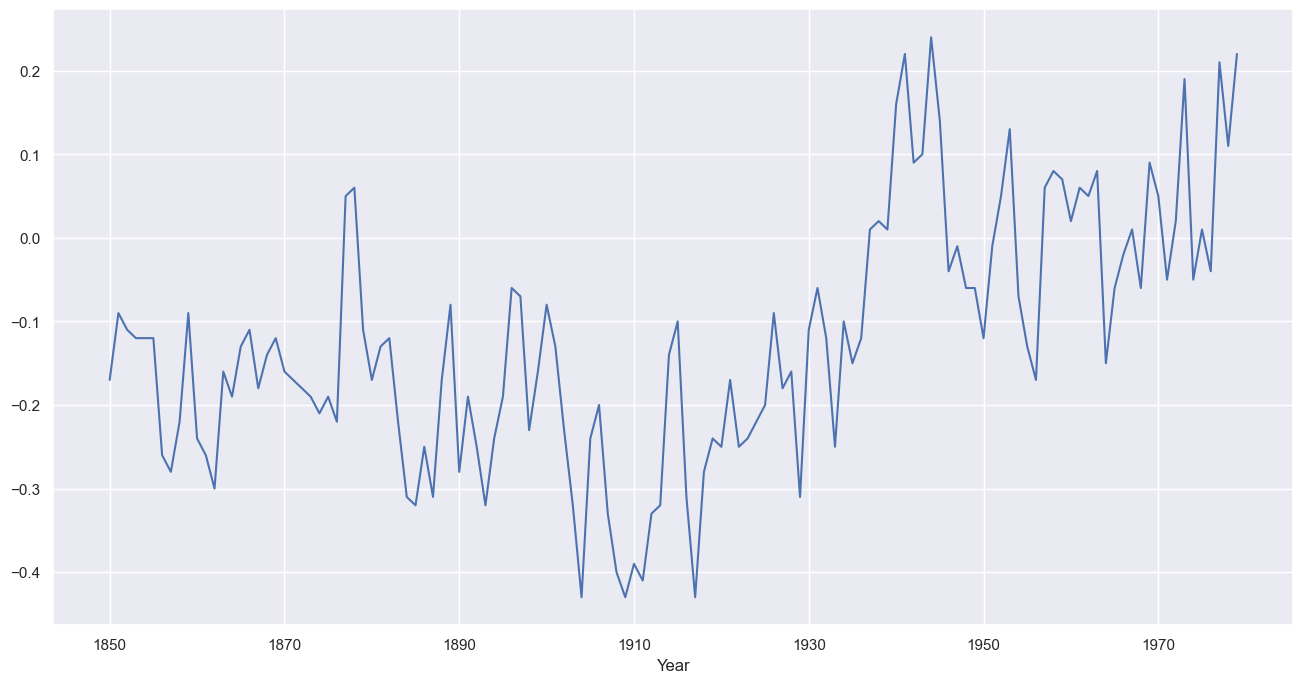

In [45]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

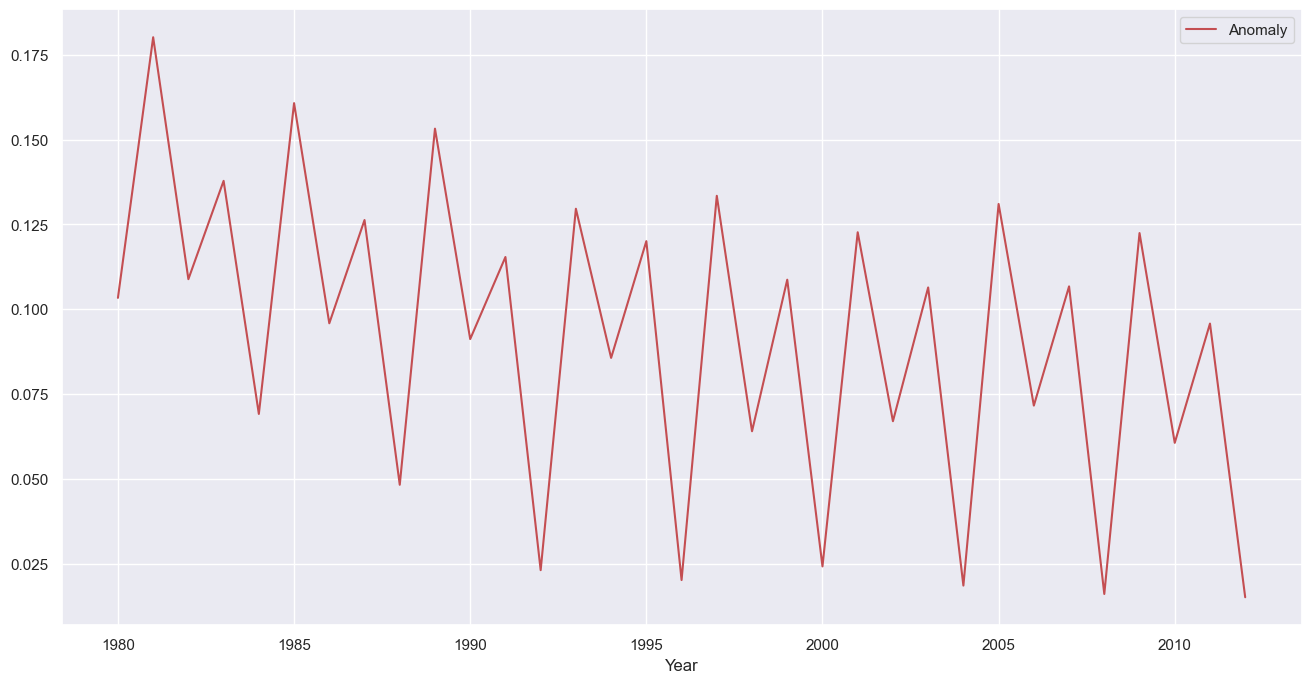

In [46]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [47]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [48]:
df.shape

(163, 12)

In [49]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [50]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016022,r
159,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122418,r
160,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060572,r
161,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.095738,r
162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015057,r


Plot combined train and forecast sets with the vertical black line as the cut-off

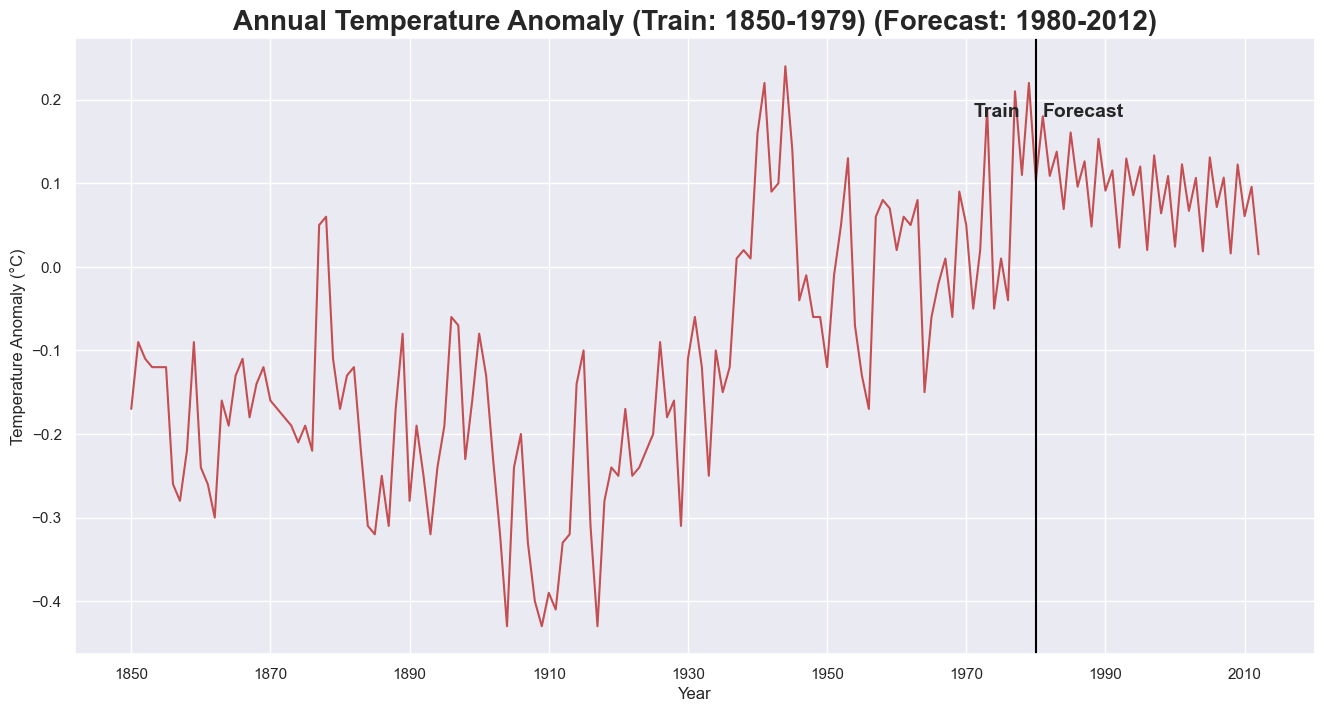

In [51]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Forecast: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

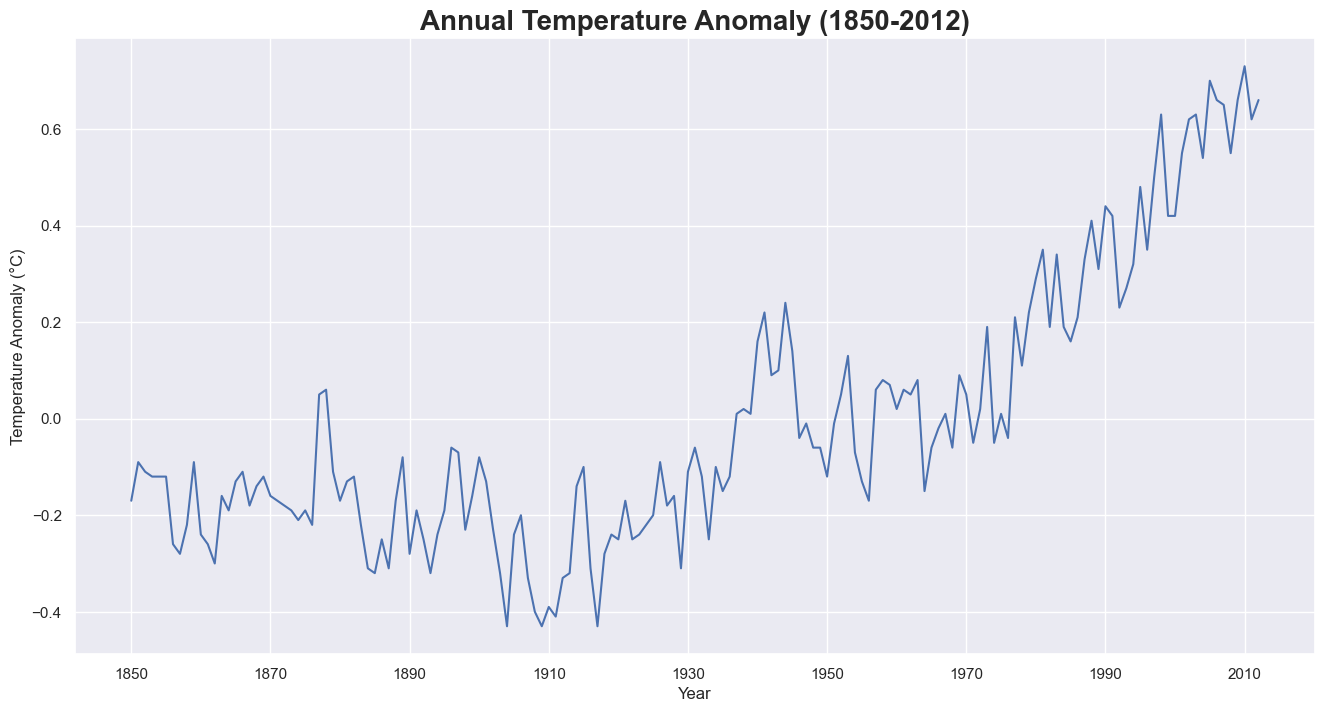

In [52]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (1850-2012)', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

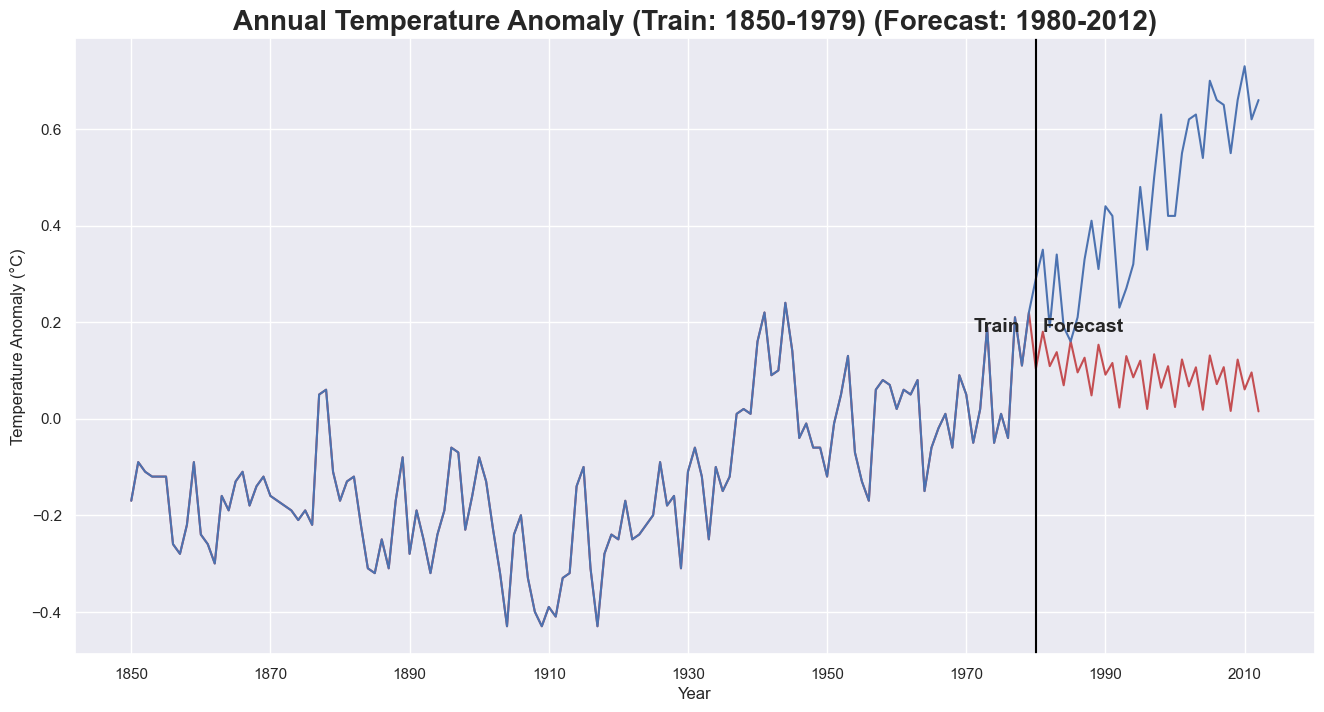

In [53]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature Anomaly (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Annual Temperature Anomaly (Train: 1850-1979) (Forecast: 1980-2012)', fontweight='bold', fontsize=20)
plt.show();